In [1]:
import warnings
warnings.filterwarnings("ignore")

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# 📦 Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import re
import string
import demoji
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 🧠 NLTK Setup (sadece gerekli bileşenler)
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def remove_emoji(text): 
    return demoji.replace(text, '')

def expand_contractions(text): # kısaltmaları uzat
    return contractions.fix(text)

def remove_non_english(text): 
    try:
        return text if detect(text) == "en" else ""
    except LangDetectException:
        return ""

def remove_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # mention/link
    text = re.sub(r'[^\x00-\x7f]', '', text)          # non-ASCII
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join(w for w in text.split() if w not in stop_words)

def lemmatize(text):
    words = text.split()  # kök formu running-run
    return ' '.join(lemmatizer.lemmatize(w) for w in words)

def remove_short_words(text, min_len=2):
    return ' '.join(w for w in text.split() if len(w) >= min_len)

def correct_elongated_words(text): # gereksiz tekrarları
    return re.sub(r'\b(\w+)((\w)\3{2,})(\w*)\b', r'\1\3\4', text)

def final_clean(text):
    text = remove_emoji(text)
    text = expand_contractions(text)
    text = remove_non_english(text)
    text = remove_all_entities(text)
    text = lemmatize(text)
    text = remove_short_words(text)
    text = correct_elongated_words(text)
    return ' '.join(text.split())


In [9]:
# 🔹 Veri setini yükle
df = pd.read_csv("dataset.csv")

# 🔹 Metni temizle
df["text_clean"] = df["tweet_text"].astype(str).apply(final_clean)

# 🔹 Boş/kısa/tekrarlı verileri at
df = df[df["text_clean"].str.strip() != ""]
df = df.drop_duplicates(subset="text_clean")
df = df[df["text_clean"].str.split().str.len() >= 3]

# 🔹 Etiketleri encode et
le = LabelEncoder()
df["label"] = le.fit_transform(df["cyberbullying_type"])

# 🔹 Eğitim ve test verisi ayır
X = df["text_clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Temiz veri hazır. Eğitim:", len(X_train), "Test:", len(X_test))
for i, label in enumerate(le.classes_):
    print(f"{i} → {label}")


✅ Temiz veri hazır. Eğitim: 29075 Test: 7269
0 → age
1 → ethnicity
2 → gender
3 → not_cyberbullying
4 → other_cyberbullying
5 → religion


In [10]:
# 🔹 Her bir sınıf için temizlenmiş tweet sayısı
class_counts = df["label"].value_counts().sort_index()
for i, count in class_counts.items():
    print(f"{i} → {le.classes_[i]}: {count} tweet")

0 → age: 6841 tweet
1 → ethnicity: 6493 tweet
2 → gender: 6381 tweet
3 → not_cyberbullying: 5292 tweet
4 → other_cyberbullying: 4406 tweet
5 → religion: 6931 tweet


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [14]:
max_words = 20000
maxlen = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
# Tüm dizileri 100 kelime uzunluğuna doldurur (kısaysa sıfır ekler; uzunsa keser).
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

In [15]:
embedding_dim = 200  

# GloVe dosyasını oku vektör
embedding_index = {}
with open("glove.6B.200d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"✅ GloVe kelime sayısı: {len(embedding_index)}")

✅ GloVe kelime sayısı: 400000


In [16]:
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("✅ Embedding matrix hazır:", embedding_matrix.shape)


✅ Embedding matrix hazır: (20000, 200)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [18]:
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

In [19]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        # inputs: [batch_size, timesteps, hidden_size]
        score = tf.nn.softmax(tf.keras.backend.sum(inputs, axis=2, keepdims=True), axis=1)
        context = inputs * score
        context = tf.reduce_sum(context, axis=1)
        return context

In [20]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam

input_ = Input(shape=(100,))
x = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=100,
    trainable=True  
)(input_)

x = GRU(128, return_sequences=True)(x)
x = AttentionLayer()(x)

# 🔽 Yeni dense bloğu burada
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

output = Dense(6, activation='softmax')(x)

model = Model(inputs=input_, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 200)            │       4,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 128)            │         126,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,151,878 (15.84 MB)

 Trainable params: 4,151,878 (15.84 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("gruudene_attention_model.h5", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop, checkpoint]
)

print("✅ Eğitim tamamlandı. En iyi model 'gru200_attention_model.h5' olarak kaydedildi.")


Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 63s 256ms/step - accuracy: 0.6827 - loss: 0.8371 - val_accuracy: 0.8199 - val_loss: 0.4476
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 61s 270ms/step - accuracy: 0.8374 - loss: 0.4033 - val_accuracy: 0.8439 - val_loss: 0.4004
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - accuracy: 0.8777 - loss: 0.3107 - val_accuracy: 0.8547 - val_loss: 0.3735
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 59s 258ms/step - accuracy: 0.9106 - loss: 0.2425 - val_accuracy: 0.8557 - val_loss: 0.3952
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - accuracy: 0.9395 - loss: 0.1714 - val_accuracy: 0.8521 - val_loss: 0.4620
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.9566 - loss: 0.1286 - val_accuracy: 0.8436 - val_loss: 0.5382
✅ Eğitim tamamlandı. En iyi model 'gru200_attention_model.h5' olarak kaydedildi.


228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step
✅ Test Doğruluğu: 0.8547
📉 Test Kayıp: 0.3735

📄 Classification Report:
                     precision    recall  f1-score   support

                age       0.97      0.97      0.97      1368
          ethnicity       0.97      0.97      0.97      1299
             gender       0.92      0.85      0.88      1276
  not_cyberbullying       0.61      0.60      0.61      1059
other_cyberbullying       0.59      0.66      0.62       881
           religion       0.95      0.95      0.95      1386

           accuracy                           0.85      7269
          macro avg       0.84      0.83      0.83      7269
       weighted avg       0.86      0.85      0.86      7269



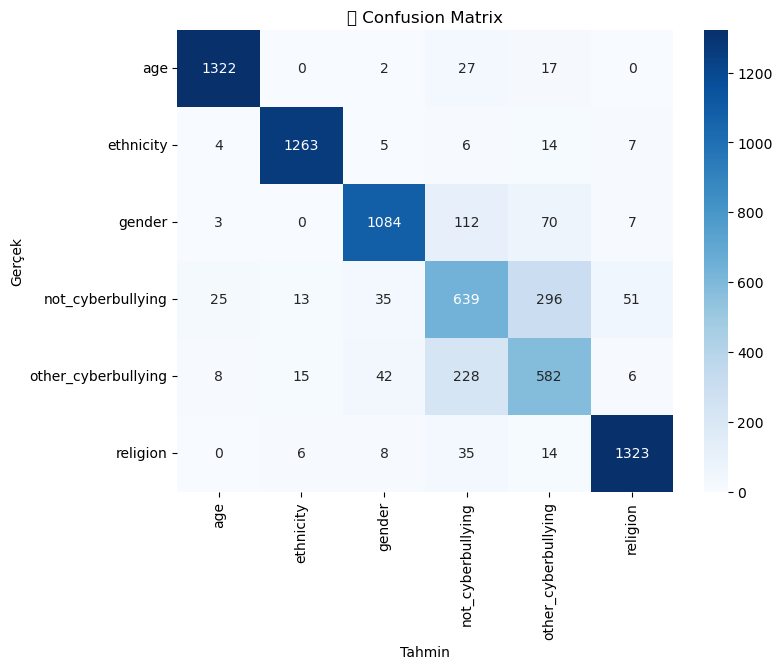

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🔹 1. Test seti üzerinde tahmin yap
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# 🔹 2. Genel test doğruluğu
loss, accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"✅ Test Doğruluğu: {accuracy:.4f}")
print(f"📉 Test Kayıp: {loss:.4f}")

# 🔹 3. Sınıf bazlı metrikler
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 🔹 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("🧩 Confusion Matrix")
plt.show()


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Eğitim verisinden alınan X_train kullanılmalı

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


# dataset 

326/326 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step
✅ Test set accuracy: 0.8494

📋 Classification Report:

                     precision    recall  f1-score   support

                age     0.9877    0.9761    0.9819      6992
          ethnicity     0.9821    0.9382    0.9597      6961
             gender     0.9403    0.8375    0.8859      6973
  not_cyberbullying     0.5809    0.7715    0.6627      6945
other_cyberbullying     0.7278    0.5937    0.6540      6823
           religion     0.9547    0.9728    0.9637      6998

           accuracy                         0.8494     41692
          macro avg     0.8622    0.8483    0.8513     41692
       weighted avg     0.8630    0.8494    0.8522     41692

Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):

                      age  ethnicity  gender  not_cyberbullying  \
age                  6825          6       5                110   
ethnicity               6       6531       9                362   
gender                  8     

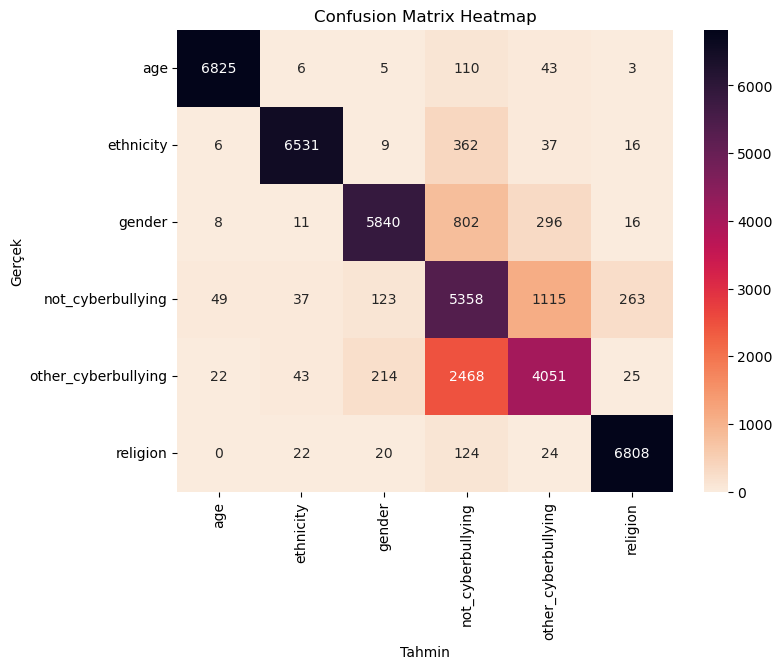

In [30]:
# 1) Gerekli kütüphaneler
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import final_clean, AttentionLayer
from sklearn.metrics import classification_report, accuracy_score

df_test = pd.read_csv("dataset.csv")

# 3) Metinleri aynı şekilde temizle
df_test["text_clean"] = df_test["tweet_text"].astype(str).apply(final_clean)

label_map = {
    "age": 0,
    "ethnicity": 1,
    "gender": 2,
    "not_cyberbullying": 3,
    "other_cyberbullying": 4,
    "religion": 5
}
y_true = df_test["cyberbullying_type"].map(label_map).values

# 5) Model ve tokenizer’ı yükle
model = load_model(
    "gruudene_attention_model.h5",
    custom_objects={'AttentionLayer': AttentionLayer}
)
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# 6) Test metinlerini tokenize + pad et
MAXLEN = 100  
seqs = tokenizer.texts_to_sequences(df_test["text_clean"])
X_test_pad = pad_sequences(seqs, maxlen=MAXLEN, padding="post", truncating="post")

# 7) Tahmin et ve y_pred oluştur
probs = model.predict(X_test_pad, batch_size=128, verbose=1)
y_pred = probs.argmax(axis=1)

# 8) Performans metrikleri
acc = accuracy_score(y_true, y_pred)
print(f"✅ Test set accuracy: {acc:.4f}\n")

print("📋 Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=list(label_map.keys()),
    digits=4
))

# 9) Confusion Matrix ve Görselleştirme

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Etiket isimleri (label_map’in tersini alabilir veya doğrudan le.classes_ kullanabilirsin)
labels = ["age","ethnicity","gender","not_cyberbullying","other_cyberbullying","religion"]

# 1️⃣ Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 2️⃣ Matrisin metin çıktısı
print("Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):\n")
print(pd.DataFrame(cm, index=labels, columns=labels))

# 3️⃣ Isı haritası çizimi
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket_r",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix Heatmap")
plt.show()


# test

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step
✅ Test set accuracy: 0.8047

📋 Classification Report:

                     precision    recall  f1-score   support

                age     0.9728    0.9660    0.9694      1000
          ethnicity     0.9643    0.9180    0.9406      1000
             gender     0.9079    0.8080    0.8550      1000
  not_cyberbullying     0.5023    0.6520    0.5674      1000
other_cyberbullying     0.6240    0.5260    0.5708      1000
           religion     0.9355    0.9580    0.9466      1000

           accuracy                         0.8047      6000
          macro avg     0.8178    0.8047    0.8083      6000
       weighted avg     0.8178    0.8047    0.8083      6000

Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):

                     age  ethnicity  gender  not_cyberbullying  \
age                  966          0       1                 22   
ethnicity              1        918       1                 70   
gender                 1          3 

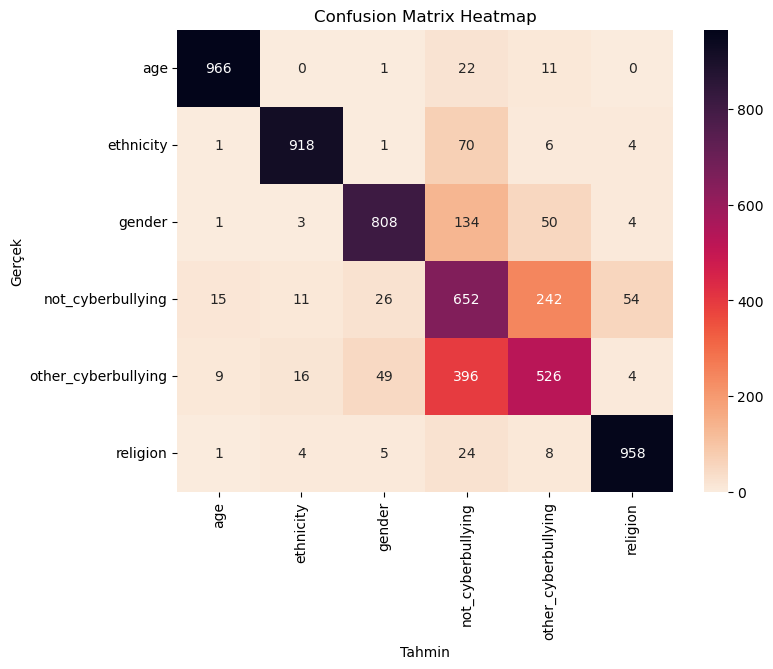

In [31]:
# 1) Gerekli kütüphaneler
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import final_clean, AttentionLayer
from sklearn.metrics import classification_report, accuracy_score

df_test = pd.read_csv("test.csv")

# 3) Metinleri aynı şekilde temizle
df_test["text_clean"] = df_test["tweet_text"].astype(str).apply(final_clean)

label_map = {
    "age": 0,
    "ethnicity": 1,
    "gender": 2,
    "not_cyberbullying": 3,
    "other_cyberbullying": 4,
    "religion": 5
}
y_true = df_test["cyberbullying_type"].map(label_map).values

# 5) Model ve tokenizer’ı yükle
model = load_model(
    "gruudene_attention_model.h5",
    custom_objects={'AttentionLayer': AttentionLayer}
)
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# 6) Test metinlerini tokenize + pad et
MAXLEN = 100  
seqs = tokenizer.texts_to_sequences(df_test["text_clean"])
X_test_pad = pad_sequences(seqs, maxlen=MAXLEN, padding="post", truncating="post")

# 7) Tahmin et ve y_pred oluştur
probs = model.predict(X_test_pad, batch_size=128, verbose=1)
y_pred = probs.argmax(axis=1)

# 8) Performans metrikleri
acc = accuracy_score(y_true, y_pred)
print(f"✅ Test set accuracy: {acc:.4f}\n")

print("📋 Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=list(label_map.keys()),
    digits=4
))


# 9) Confusion Matrix ve Görselleştirme

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Etiket isimleri (label_map’in tersini alabilir veya doğrudan le.classes_ kullanabilirsin)
labels = ["age","ethnicity","gender","not_cyberbullying","other_cyberbullying","religion"]

# 1️⃣ Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 2️⃣ Matrisin metin çıktısı
print("Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):\n")
print(pd.DataFrame(cm, index=labels, columns=labels))

# 3️⃣ Isı haritası çizimi
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket_r",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix Heatmap")
plt.show()


## sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
✅ Test set accuracy: 0.8500

📋 Classification Report:

                     precision    recall  f1-score   support

                age     1.0000    1.0000    1.0000        17
          ethnicity     0.9444    1.0000    0.9714        17
             gender     1.0000    0.9412    0.9697        17
  not_cyberbullying     0.5652    0.7647    0.6500        17
other_cyberbullying     0.6667    0.3750    0.4800        16
           religion     0.9412    1.0000    0.9697        16

           accuracy                         0.8500       100
          macro avg     0.8529    0.8468    0.8401       100
       weighted avg     0.8539    0.8500    0.8424       100

Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):

                     age  ethnicity  gender  not_cyberbullying  \
age                   17          0       0                  0   
ethnicity              0         17       0                  0   
gender                 0          0  

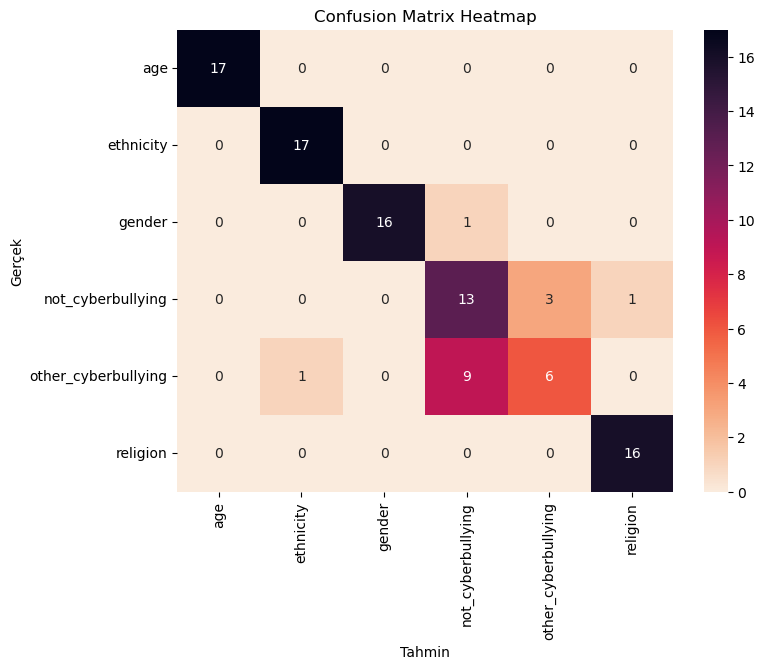

In [32]:
# 1) Gerekli kütüphaneler
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import final_clean, AttentionLayer
from sklearn.metrics import classification_report, accuracy_score

df_test = pd.read_csv("sample_dataset.csv")

# 3) Metinleri aynı şekilde temizle
df_test["text_clean"] = df_test["tweet_text"].astype(str).apply(final_clean)

label_map = {
    "age": 0,
    "ethnicity": 1,
    "gender": 2,
    "not_cyberbullying": 3,
    "other_cyberbullying": 4,
    "religion": 5
}
y_true = df_test["cyberbullying_type"].map(label_map).values

# 5) Model ve tokenizer’ı yükle
model = load_model(
    "gruudene_attention_model.h5",
    custom_objects={'AttentionLayer': AttentionLayer}
)
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# 6) Test metinlerini tokenize + pad et
MAXLEN = 100  
seqs = tokenizer.texts_to_sequences(df_test["text_clean"])
X_test_pad = pad_sequences(seqs, maxlen=MAXLEN, padding="post", truncating="post")

# 7) Tahmin et ve y_pred oluştur
probs = model.predict(X_test_pad, batch_size=128, verbose=1)
y_pred = probs.argmax(axis=1)

# 8) Performans metrikleri
acc = accuracy_score(y_true, y_pred)
print(f"✅ Test set accuracy: {acc:.4f}\n")

print("📋 Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=list(label_map.keys()),
    digits=4
))


# 9) Confusion Matrix ve Görselleştirme

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Etiket isimleri (label_map’in tersini alabilir veya doğrudan le.classes_ kullanabilirsin)
labels = ["age","ethnicity","gender","not_cyberbullying","other_cyberbullying","religion"]

# 1️⃣ Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 2️⃣ Matrisin metin çıktısı
print("Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):\n")
print(pd.DataFrame(cm, index=labels, columns=labels))

# 3️⃣ Isı haritası çizimi
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket_r",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix Heatmap")
plt.show()
